# Machine Learning Pre-Processing Workflow 

After EDA, the next part is called (pre/signal)-processing. The aim is to get to the data matrix, so that it can be used for Machine Learning. 

To do-list: 
- EDA = clean the data.
- Extract meaningfull features from the data.
- Construct the data matrix.

In [1]:
import copy  # to copy variables

import numpy as np # To do some calculations

import pandas as pd # To work with dataframes (easier matrices)

import datetime as dt # to work with time/date

from os import listdir # To get a list of files in a folder

import matplotlib.image as img # To load the images

import matplotlib.pyplot as plt # To plot the images

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier # The machine learning model 

## The Data 

The raw signal:
- HF => Heart 
- FiO2 => Administered oxygen 
- SpO2 => Oxygen saturation 
- Taxillair => Temperature

Metadata:
- Choose which ones you want to include in your final data matrix:
    - "gestational_age" => the age at birth in weeks (9 months = ca. 40 weeks)

End_of_stay_disease:
- In this file, you can find which patients are of the sick type.


Notes: 
- The patients are healthy at the start of the data for at least 2 days. 
- Some patients get sick at the end of the data. The last days, these patients are definitely sick but possibly already longer. 

Procedure: 
- Start with 1 patient, at the end loop over all patients.
- Do 1 signal (HF, FiO2, SpO2, Taxillair) at a time. 
- Clean the signal.
- Calculate metrics/features on this signal (or other derived signal) and add these to an array/initialized matrix. 
    - Example of a feature: the average heart rate in the last 24 hours => be creative here. 
- Repeat for all signals
- Think whether you want to include some metadata into your feature matrix.
- If everything calculates correct, write it into a loop and keep track of the outcome (healthy vs disease)

Note: 
- You should have a matrix at the end.
- How many rows & columns depends on your approach. 
- Produce more rows with the data => this will help your machine learning. 
- Think of different features/metrics, the more different they are, the more chance you have of getting some crucial patterns. 
- There is an example of how to accumulate features (columns) in an empty matrix, see the flower notebook from the first lesson. 

### Exploratory Data Analysis - Patient Rawsignals

Taking a closer look at the data

In [2]:
df_rawsignals = pd.read_csv("patient_rawsignals.txt", header = 0, sep = ";")

#returns the first 5 observations & the last 5 observations
df_rawsignals

,time,value,NICU_ID,field,measurement,hospital_ID,patient_ID,signal_type
0,1.630454e+09,171,Bed 1,signal_value,rawsignal,UZA,257777778,HF
1,1.630454e+09,170,Bed 1,signal_value,rawsignal,UZA,257777778,HF
2,1.630454e+09,170,Bed 1,signal_value,rawsignal,UZA,257777778,HF
3,1.630454e+09,170,Bed 1,signal_value,rawsignal,UZA,257777778,HF
4,1.630455e+09,169,Bed 1,signal_value,rawsignal,UZA,257777778,HF
...,...,...,...,...,...,...,...,...
1988552,1.638763e+09,99,Bed 6,signal_value,rawsignal,UZA,257777807,Taxillair
1988553,1.638778e+09,101,Bed 6,signal_value,rawsignal,UZA,257777807,Taxillair
1988554,1.638792e+09,100,Bed 6,signal_value,rawsignal,UZA,257777807,Taxillair
1988555,1.638806e+09,102,Bed 6,signal_value,rawsignal,UZA,257777807,Taxillair


In [3]:
#total number of rows&columns
df_rawsignals.shape 

(1988557, 8)

In [4]:
#detect missing values
df_rawsignals.isnull().sum() 

time           0
value          0
NICU_ID        0
field          0
measurement    0
hospital_ID    0
patient_ID     0
signal_type    0
dtype: int64

In [5]:
df_rawsignals["time"] = pd.to_datetime(df_rawsignals["time"], unit = "s")
df_rawsignals

,time,value,NICU_ID,field,measurement,hospital_ID,patient_ID,signal_type
0,2021-09-01 00:00:10,171,Bed 1,signal_value,rawsignal,UZA,257777778,HF
1,2021-09-01 00:00:40,170,Bed 1,signal_value,rawsignal,UZA,257777778,HF
2,2021-09-01 00:01:10,170,Bed 1,signal_value,rawsignal,UZA,257777778,HF
3,2021-09-01 00:01:40,170,Bed 1,signal_value,rawsignal,UZA,257777778,HF
4,2021-09-01 00:02:10,169,Bed 1,signal_value,rawsignal,UZA,257777778,HF
...,...,...,...,...,...,...,...,...
1988552,2021-12-06 04:00:43,99,Bed 6,signal_value,rawsignal,UZA,257777807,Taxillair
1988553,2021-12-06 08:00:43,101,Bed 6,signal_value,rawsignal,UZA,257777807,Taxillair
1988554,2021-12-06 12:00:43,100,Bed 6,signal_value,rawsignal,UZA,257777807,Taxillair
1988555,2021-12-06 16:00:43,102,Bed 6,signal_value,rawsignal,UZA,257777807,Taxillair


In [6]:
#take necessary columns 
df_rawsignals = df_rawsignals[["time", "value", "patient_ID", "signal_type"]]

#returns the first 5 observations & the last 5 observations
df_rawsignals

,time,value,patient_ID,signal_type
0,2021-09-01 00:00:10,171,257777778,HF
1,2021-09-01 00:00:40,170,257777778,HF
2,2021-09-01 00:01:10,170,257777778,HF
3,2021-09-01 00:01:40,170,257777778,HF
4,2021-09-01 00:02:10,169,257777778,HF
...,...,...,...,...
1988552,2021-12-06 04:00:43,99,257777807,Taxillair
1988553,2021-12-06 08:00:43,101,257777807,Taxillair
1988554,2021-12-06 12:00:43,100,257777807,Taxillair
1988555,2021-12-06 16:00:43,102,257777807,Taxillair


### 1 Patient

#### HF - Heart Rate

In [7]:
HF = df_rawsignals.loc[np.logical_and(df_rawsignals['signal_type'] == "HF", df_rawsignals['patient_ID'] == 257777778)]
HF

,time,value,patient_ID,signal_type
0,2021-09-01 00:00:10,171,257777778,HF
1,2021-09-01 00:00:40,170,257777778,HF
2,2021-09-01 00:01:10,170,257777778,HF
3,2021-09-01 00:01:40,170,257777778,HF
4,2021-09-01 00:02:10,169,257777778,HF
...,...,...,...,...
28795,2021-09-10 23:57:40,184,257777778,HF
28796,2021-09-10 23:58:10,184,257777778,HF
28797,2021-09-10 23:58:40,184,257777778,HF
28798,2021-09-10 23:59:10,184,257777778,HF


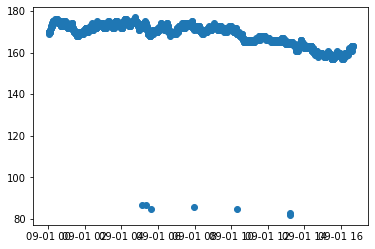

In [8]:
HF_sub = HF.iloc[1:2000]
plt.scatter(HF_sub['time'], HF_sub['value'])

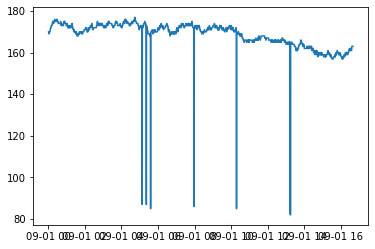

In [9]:
plt.plot(HF_sub['time'], HF_sub['value'])

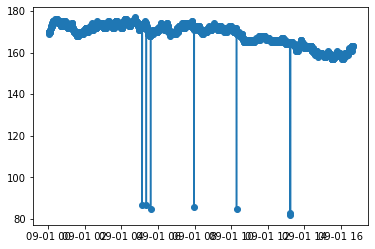

In [10]:
plt.scatter(HF_sub['time'], HF_sub['value'])
plt.plot(HF_sub['time'], HF_sub['value'])

##### Metrics/Features - HF, Heart Rate

In [11]:
#the average heart rate 
HF_average = np.mean(HF["value"])
HF_average

176.5703125

In [12]:
#the highest heart rate 
HF_highest = np.max(HF["value"])
HF_highest

206

In [13]:
#the lowest heart rate 
HF_lowest = np.min(HF["value"])
HF_lowest

79

#### FiO2 - Administered Oxygen

In [14]:
FiO2 = df_rawsignals.loc[np.logical_and(df_rawsignals['signal_type'] == "FiO2", df_rawsignals['patient_ID'] == 257777778)]
FiO2

,time,value,patient_ID,signal_type
57600,2021-09-01 00:00:53,21,257777778,FiO2
57601,2021-09-01 00:01:23,21,257777778,FiO2
57602,2021-09-01 00:01:53,21,257777778,FiO2
57603,2021-09-01 00:02:23,21,257777778,FiO2
57604,2021-09-01 00:02:53,21,257777778,FiO2
...,...,...,...,...
86394,2021-09-10 23:57:53,21,257777778,FiO2
86395,2021-09-10 23:58:23,21,257777778,FiO2
86396,2021-09-10 23:58:53,21,257777778,FiO2
86397,2021-09-10 23:59:23,21,257777778,FiO2


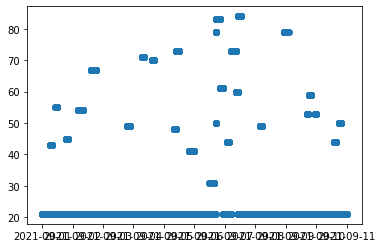

In [15]:
FiO2_sub = FiO2.loc[FiO2['value'] < 98]   #.iloc[1:1000]
plt.scatter(FiO2_sub['time'], FiO2_sub['value'])

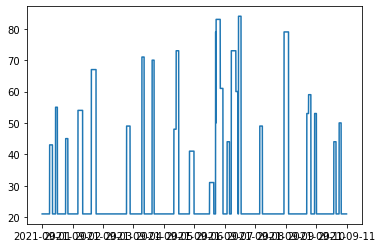

In [16]:
plt.plot(FiO2_sub['time'], FiO2_sub['value'])

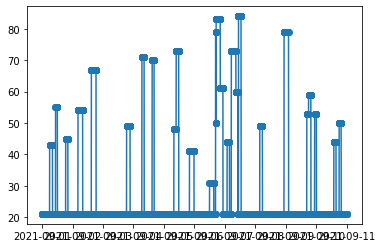

In [17]:
plt.scatter(FiO2_sub['time'], FiO2_sub['value'])
plt.plot(FiO2_sub['time'], FiO2_sub['value'])

##### Metrics/Features - FiO2, Administered Oxygen 

In [18]:
#the average administered oxygen 
FiO2_average = np.mean(FiO2["value"])
FiO2_average

30.420153477551303

In [19]:
#the highest administered oxygen 
FiO2_highest = np.max(FiO2["value"])
FiO2_highest

100

In [20]:
#the lowest administered oxygen 
FiO2_lowest = np.min(FiO2["value"])
FiO2_lowest

21

#### SpO2 - Oxygen Saturation 

In [21]:
SpO2 = df_rawsignals.loc[np.logical_and(df_rawsignals['signal_type'] == "SpO2", df_rawsignals['patient_ID'] == 257777778)]
SpO2

,time,value,patient_ID,signal_type
28800,2021-09-01 00:00:15,89,257777778,SpO2
28801,2021-09-01 00:00:45,89,257777778,SpO2
28802,2021-09-01 00:01:15,89,257777778,SpO2
28803,2021-09-01 00:01:45,89,257777778,SpO2
28804,2021-09-01 00:02:15,90,257777778,SpO2
...,...,...,...,...
57595,2021-09-10 23:57:45,75,257777778,SpO2
57596,2021-09-10 23:58:15,75,257777778,SpO2
57597,2021-09-10 23:58:45,75,257777778,SpO2
57598,2021-09-10 23:59:15,75,257777778,SpO2


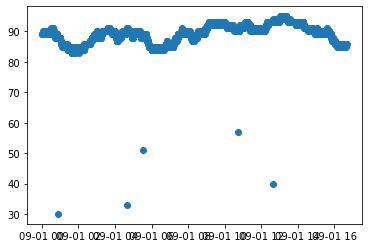

In [22]:
SpO2_sub = SpO2.iloc[1:2000]
plt.scatter(SpO2_sub['time'], SpO2_sub['value'])

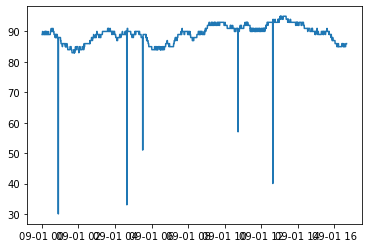

In [23]:
plt.plot(SpO2_sub['time'], SpO2_sub['value'])

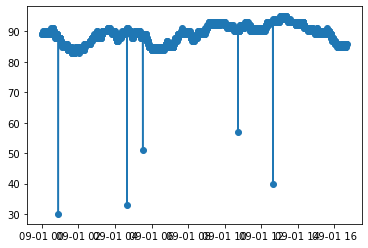

In [24]:
plt.scatter(SpO2_sub['time'], SpO2_sub['value'])
plt.plot(SpO2_sub['time'], SpO2_sub['value'])

##### Metrics/Features - SpO2, Oxygen Saturation

In [25]:
#the average oxygen saturation
SpO2_average = np.mean(SpO2["value"])
SpO2_average

79.00309027777777

In [26]:
#the highest oxygen saturation
SpO2_highest = np.max(SpO2["value"])
SpO2_highest

100

In [27]:
#the lowest oxygen saturation
SpO2_lowest = np.min(SpO2["value"])
SpO2_lowest

30

#### Taxillair - Temperature 

In [28]:
Temperature = df_rawsignals.loc[np.logical_and(df_rawsignals['signal_type'] == "Taxillair", df_rawsignals['patient_ID'] == 257777778)]
Temperature

,time,value,patient_ID,signal_type
86399,2021-09-01 00:00:43,97,257777778,Taxillair
86400,2021-09-01 04:00:43,99,257777778,Taxillair
86401,2021-09-01 08:00:43,98,257777778,Taxillair
86402,2021-09-01 12:00:43,103,257777778,Taxillair
86403,2021-09-01 16:00:43,97,257777778,Taxillair
86404,2021-09-01 20:00:43,99,257777778,Taxillair
86405,2021-09-02 00:00:43,98,257777778,Taxillair
86406,2021-09-02 04:00:43,102,257777778,Taxillair
86407,2021-09-02 08:00:43,97,257777778,Taxillair
86408,2021-09-02 12:00:43,103,257777778,Taxillair


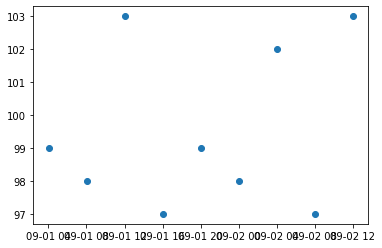

In [29]:
Temperature_sub = Temperature.iloc[1:10]
plt.scatter(Temperature_sub['time'], Temperature_sub['value'])

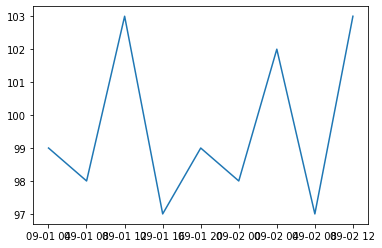

In [30]:
plt.plot(Temperature_sub['time'], Temperature_sub['value'])

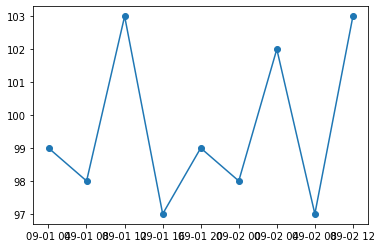

In [31]:
plt.scatter(Temperature_sub['time'], Temperature_sub['value'])
plt.plot(Temperature_sub['time'], Temperature_sub['value'])

##### Metrics/Features - Taxillair

In [32]:
#the average temperature 
Temperature_average = np.mean(Temperature["value"])
Temperature_average

99.86666666666666

In [33]:
#the highest temperature
Temperature_highest = np.max(Temperature["value"])
Temperature_highest

104

In [34]:
#the lowest temperature 
Temperature_lowest = np.min(Temperature["value"])
Temperature_lowest

97

### Exploratory Data Analysis - Patient Metadata

Taking a closer look at the data

In [35]:
df_metadata = pd.read_csv("patient_meta.txt", sep=";")

#returns the first 5 observations & the last 5 observations
df_metadata

,time,value,field,measurement,hospital_ID,patient_ID
0,2021-09-01T00:09:00Z,34.87,gestational_age,patient,UZA,257777778
1,1921-09-01T00:09:00Z,1895,birth_weight,patient,UZA,257777778
2,2021-09-01T00:09:00Z,Bed 1,NICU_ID,patient,UZA,257777778
3,2021-09-01T00:09:00Z,Aa1,firstname,patient,UZA,257777778
4,2021-09-01T00:09:00Z,Bb1,lastname,patient,UZA,257777778
...,...,...,...,...,...,...
156,2021-11-27T00:11:00Z,Bed 6,NICU_ID,patient,UZA,257777807
157,2021-11-27T00:11:00Z,Aa30,firstname,patient,UZA,257777807
158,2021-11-27T00:11:00Z,Bb30,lastname,patient,UZA,257777807
159,2021-11-27T00:11:00Z,2021-11-25 06:00:00,date_of_birth,patient,UZA,257777807


In [36]:
#total number of rows&columns
df_metadata.shape

(161, 6)

In [37]:
#detect missing values
df_metadata.isnull().sum()

time           0
value          0
field          0
measurement    0
hospital_ID    0
patient_ID     0
dtype: int64

In [38]:
#necessary columns 
df_metadata = df_metadata[["value", "field", "patient_ID"]]
df_metadata

,value,field,patient_ID
0,34.87,gestational_age,257777778
1,1895,birth_weight,257777778
2,Bed 1,NICU_ID,257777778
3,Aa1,firstname,257777778
4,Bb1,lastname,257777778
...,...,...,...
156,Bed 6,NICU_ID,257777807
157,Aa30,firstname,257777807
158,Bb30,lastname,257777807
159,2021-11-25 06:00:00,date_of_birth,257777807


In [39]:
#choose which ones you want to add to the matrix
df_metadata.field.unique()

array(['gestational_age', 'birth_weight', 'NICU_ID', 'firstname',
       'lastname', 'date_of_birth', 'discharge'], dtype=object)

In [40]:
#only "gestational_age" and "birth_weight" will be added to the matrix
df_metadata = df_metadata.pivot(index="patient_ID", columns = "field", values="value")
df_metadata = df_metadata[["gestational_age", "birth_weight", "discharge"]]
df_metadata

field,gestational_age,birth_weight,discharge
patient_ID,,,
257777778,34.87,1895,true
257777779,27.77,1030,true
257777781,23.84,0.556,true
257777783,32.5,1615,true
257777785,34.66,1873,true
257777786,24.99,714,true
257777787,28.51,1125,true
257777788,25.06,721,true
257777789,25.78,795,true


### Exploratory Data Analysis - End of Stay Disease

Take a closer look at the data

In [41]:
df_sick = pd.read_csv("End_of_stay_disease.txt", header=None)
df_sick

,0
0,257777781
1,257777788
2,257777790
3,257777793
4,257777795
5,257777796
6,257777798
7,257777803
8,257777804
9,257777805


In [42]:
#NO NEED FOR RENAMING
#rename the column 
#df_status.rename(columns = {0 :'sick'}) #OR df_status.rename(columns = {0 :'sick_patient_ID'}, inpalce = True)

In [43]:
#convert pandas column to list 
sick_list = list(df_sick[0])
sick_list

[257777781,
 257777788,
 257777790,
 257777793,
 257777795,
 257777796,
 257777798,
 257777803,
 257777804,
 257777805]

In [44]:
#adding new column, status, with all the values=false
df_metadata["status"] = "healthy"

In [45]:
index = 0
while (index < len(sick_list)):
    df_metadata.loc[df_metadata.index == sick_list[index], "status"] = "sick"
    index+=1

df_metadata

field,gestational_age,birth_weight,discharge,status
patient_ID,,,,
257777778,34.87,1895,true,healthy
257777779,27.77,1030,true,healthy
257777781,23.84,0.556,true,sick
257777783,32.5,1615,true,healthy
257777785,34.66,1873,true,healthy
257777786,24.99,714,true,healthy
257777787,28.51,1125,true,healthy
257777788,25.06,721,true,sick
257777789,25.78,795,true,healthy


In [46]:
#copy df_metadata
outcome_data = df_metadata.copy()
outcome_data

field,gestational_age,birth_weight,discharge,status
patient_ID,,,,
257777778,34.87,1895,true,healthy
257777779,27.77,1030,true,healthy
257777781,23.84,0.556,true,sick
257777783,32.5,1615,true,healthy
257777785,34.66,1873,true,healthy
257777786,24.99,714,true,healthy
257777787,28.51,1125,true,healthy
257777788,25.06,721,true,sick
257777789,25.78,795,true,healthy


In [47]:
#drop columnns in df_metadata
#the remaing columns will be included in the matrix 
df_metadata.drop("discharge", inplace=True, axis=1)
df_metadata.drop("status", inplace=True, axis=1)
df_metadata

field,gestational_age,birth_weight
patient_ID,,
257777778,34.87,1895
257777779,27.77,1030
257777781,23.84,0.556
257777783,32.5,1615
257777785,34.66,1873
257777786,24.99,714
257777787,28.51,1125
257777788,25.06,721
257777789,25.78,795


## Building the Outcome Vector

In [48]:
#drop columns in outcome_data
outcome_data.drop("gestational_age", inplace=True, axis=1)
outcome_data.drop("birth_weight", inplace=True, axis=1)
outcome_data

field,discharge,status
patient_ID,,
257777778,true,healthy
257777779,true,healthy
257777781,true,sick
257777783,true,healthy
257777785,true,healthy
257777786,true,healthy
257777787,true,healthy
257777788,true,sick
257777789,true,healthy


## Data Matrix

In [49]:
matrix = np.empty((0, 14), float) #initialization of an empty ndarray

rotation = 0
while (rotation < 23): 
    patient_id = np.unique(df_metadata.index)[rotation]
    
    HF = df_rawsignals.loc[np.logical_and(df_rawsignals['signal_type'] == "HF", df_rawsignals['patient_ID'] == patient_id)]
    HF_average = np.mean(HF["value"]) #the average heart rate 
    HF_highest = np.max(HF["value"]) #the highest heart rate 
    HF_lowest = np.min(HF["value"]) #the lowest heart rate 

    FiO2 = df_rawsignals.loc[np.logical_and(df_rawsignals['signal_type'] == "FiO2", df_rawsignals['patient_ID'] == patient_id)]
    FiO2_average = np.mean(FiO2["value"]) #the average FiO2
    FiO2_highest = np.max(FiO2["value"]) #the highest FiO2 
    FiO2_lowest = np.min(FiO2["value"]) #the lowest FiO2
    
    SpO2 = df_rawsignals.loc[np.logical_and(df_rawsignals['signal_type'] == "SpO2", df_rawsignals['patient_ID'] == patient_id)]
    SpO2_average = np.mean(SpO2["value"]) #the average SpO2
    SpO2_highest = np.max(SpO2["value"]) #the highest SpO2 
    SpO2_lowest = np.min(SpO2["value"]) #the lowest SpO2
    
    Temperature = df_rawsignals.loc[np.logical_and(df_rawsignals['signal_type'] == "Taxillair", df_rawsignals['patient_ID'] == patient_id)]
    Temperature_average = np.mean(Temperature["value"]) #the average temperature
    Temperature_highest = np.max(Temperature["value"]) #the highest temperature 
    Temperature_lowest = np.min(Temperature["value"]) #the lowest temperature
    
    for i, j in df_metadata.iterrows():
        Gestational_age = j['gestational_age']
        Birth_weight  = j['birth_weight']
    
    features = [[HF_average, HF_highest, HF_lowest, FiO2_average, FiO2_highest, FiO2_lowest, SpO2_average, SpO2_highest, SpO2_lowest, Temperature_average, Temperature_highest, Temperature_lowest, Gestational_age, Birth_weight]]
    matrix = np.append(matrix, features, axis = 0)
    
    rotation+=1
    
matrix

array([['176.5703125', '206', '79', '30.420153477551303', '100', '21',
        '79.00309027777777', '100', '30', '99.86666666666666', '104',
        '97', '27.35', '980'],
       ['214.42756944444446', '256', '82', '30.360081947289835', '100',
        '21', '99.52194444444444', '100', '30', '100.46666666666667',
        '104', '97', '27.35', '980'],
       ['199.7067013888889', '232', '80', '32.786277301295186', '100',
        '21', '82.12461805555556', '100', '30', '100.26666666666667',
        '104', '97', '27.35', '980'],
       ['160.20114583333333', '438', '62', '31.428869057953403', '100',
        '21', '66.39302083333334', '96', '30', '100.26666666666667',
        '104', '97', '27.35', '980'],
       ['126.53604166666666', '173', '44', '30.36035973471301', '100',
        '21', '98.44211805555555', '100', '30', '100.5', '104', '97',
        '27.35', '980'],
       ['194.2446527777778', '226', '84', '32.14590784402236', '100',
        '21', '95.29861111111111', '100', '31', '100.4

## Building the Model

In [50]:
## Step 1: defining the model
ML_model = RandomForestClassifier(n_estimators=100)

In [51]:
## Step 2: training the model with the data we prepared

ML_model.fit(matrix, outcome_data['status'])

RandomForestClassifier()

## Evaluating the Model on the Training Data

The following performance on the training data shows that the model predicted the true labels correctly. 

In [52]:
y_pred=ML_model.predict(matrix)

prediction_check = pd.DataFrame({'True label':outcome_data['status'],
                                'Predicted label': y_pred})
prediction_check

,True label,Predicted label
patient_ID,,
257777778,healthy,healthy
257777779,healthy,healthy
257777781,sick,sick
257777783,healthy,healthy
257777785,healthy,healthy
257777786,healthy,healthy
257777787,healthy,healthy
257777788,sick,sick
257777789,healthy,healthy
